In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
#             device = '/gpu:9'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

2024-09-19 18:37:43.537864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 18:37:43.551019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 18:37:43.564205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 18:37:43.568132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 18:37:43.579482: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-09-19 18:37:45.617794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-09-19 18:37:45.619343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


My model

In [5]:
# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         x_input = layers.Input(shape=self.input_shape)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
        
#         x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         # x = layers.Dropout(0.1)(x)
        
#         x = layers.Flatten()(x)
        
        
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


Josh's model

In [5]:
class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-2, weights_path=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        
        x_1 = layers.Conv2D(16, kernel_size=6, padding='same', activation='relu')(x_input)
        x_2 = layers.Conv2D(32, kernel_size=8, padding='same', activation='relu')(x_input)
        x_3 = layers.Conv2D(64, kernel_size=19, padding='same', activation='relu')(x_input)
        
        x = layers.concatenate([x_1, x_2, x_3])
        x = layers.Flatten()(x)
               
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dense(16, activation='relu')(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [7]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_5.h5'             

data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


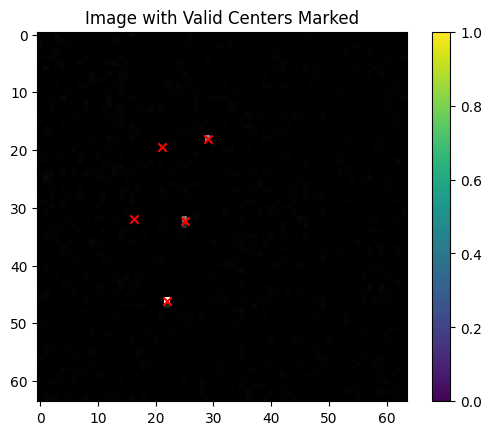

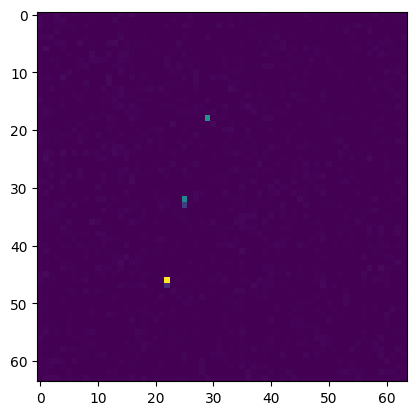

In [8]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [9]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [10]:

batch_size = 400
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (24000, 64, 64), Train Midpoints: (24000, 1, 5, 2)
Validation Images: (6000, 64, 64), Validation Midpoints: (6000, 1, 5, 2)


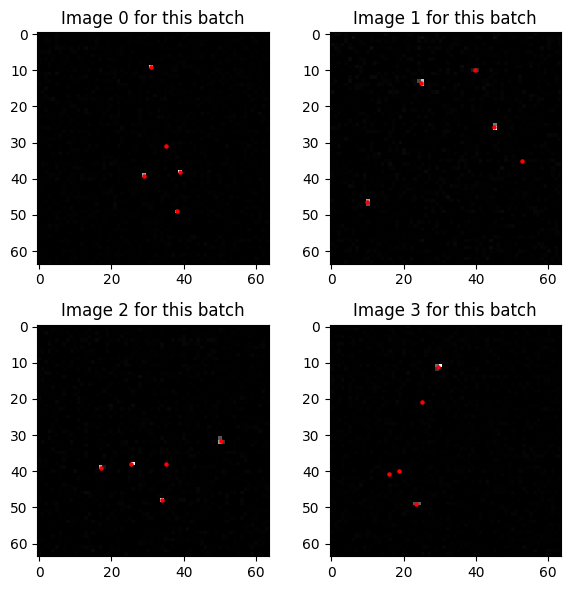

In [11]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [13]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='min', min_lr=3e-5
)


In [14]:

# Initialize the ModelBuilder within the strategy scope
with strategy.scope():
    # Instantiate the model builder
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model
    model_builder.compile_model(loss_function=tf.keras.losses.Huber())
    # model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError())
    # If using a custom loss function, replace the above line with:
    # model_builder.compile_model(loss_function=custom_loss(exponent=2))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        592 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,080 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     23,168 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 112)              │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 458752)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 29,360,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints (Dense) │ (None, 10)        │        170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints_reshape │ (None, 1, 5, 2)   │          0 │ x_midpoints[0][0] │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,388,810 (112.11 MB)

 Trainable params: 29,388,810 (112.11 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:

# Train the model
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=600,
    callbacks_list=[lr_scheduler]
)


Epoch 1/600


2024-09-19 18:38:54.915194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-19 18:38:54.924898: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726771134.992321 2437212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771134.994923 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.032079 2437212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.032227 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.033131 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.055835 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.056135 2437212 gpu_time

 1/60 ━━━━━━━━━━━━━━━━━━━━ 4:25 4s/step - loss: 0.0477

W0000 00:00:1726771135.824971 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.826677 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.827561 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.828533 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.829517 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.830650 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.831657 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.832789 2437208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771135.834047 2437208 gp

58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0370

2024-09-19 18:38:57.305572: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-19 18:38:57.305739: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-09-19 18:38:57.305812: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1726771137.664387 2437199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771137.666759 2437199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726771137.667234 2437199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be re

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0368 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 2/600
 1/60 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0260

2024-09-19 18:38:58.287870: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0255 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 3/600


2024-09-19 18:39:00.081450: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0216 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 4/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0188 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 5/600
 1/60 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0167

2024-09-19 18:39:03.901798: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0172 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 6/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0163 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 7/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0159 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 8/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0153 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 9/600
 1/60 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0148

2024-09-19 18:39:11.047628: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0150 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 10/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0146 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 11/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0141 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 12/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0137 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 13/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0135 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 14/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0133 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 15/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0128
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0128 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 16/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0122 - val_loss: 0.0184 - learning_rate:

2024-09-19 18:39:25.364341: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0119 - val_loss: 0.0187 - learning_rate: 2.0000e-04
Epoch 18/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0117 - val_loss: 0.0185 - learning_rate: 2.0000e-04
Epoch 19/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0114 - val_loss: 0.0189 - learning_rate: 2.0000e-04
Epoch 20/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0114 - val_loss: 0.0188 - learning_rate: 2.0000e-04
Epoch 21/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0113 - val_loss: 0.0189 - learning_rate: 2.0000e-04
Epoch 22/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0112 - val_loss: 0.0187 - learning_rate: 2.0000e-04
Epoch 23/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0110 - val_loss: 0.0191 - learning_rate: 2.0000e-04
Epoch 24/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0109 - val_loss: 0.0188 - learning_rate: 2.0000e-04
Epoch 25/600
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0108
Epoch 25: ReduceLROnPlate

2024-09-19 18:39:54.498144: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0104 - val_loss: 0.0187 - learning_rate: 4.0000e-05
Epoch 34/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0103 - val_loss: 0.0188 - learning_rate: 4.0000e-05
Epoch 35/600
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0104
Epoch 35: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0104 - val_loss: 0.0187 - learning_rate: 4.0000e-05
Epoch 36/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0187 - learning_rate: 8.0000e-06
Epoch 37/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0102 - val_loss: 0.0189 - learning_rate: 8.0000e-06
Epoch 38/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0103 - val_loss: 0.0187 - learning_rate: 8.0000e-06
Epoch 39/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0191 - learning_rate: 8.0000e-06
Epoch 40/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0103 - val_lo

2024-09-19 18:40:53.084931: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102
Epoch 65: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0192 - learning_rate: 3.2000e-07
Epoch 66/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0101 - val_loss: 0.0188 - learning_rate: 6.4000e-08
Epoch 67/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0184 - learning_rate: 6.4000e-08
Epoch 68/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0101 - val_loss: 0.0192 - learning_rate: 6.4000e-08
Epoch 69/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0188 - learning_rate: 6.4000e-08
Epoch 70/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0103 - val_loss: 0.0188 - learning_rate: 6.4000e-08
Epoch 71/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0101 - val_loss: 0.0189 - learning_rate: 6.4000e-08
Epoch 72/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_lo

2024-09-19 18:42:53.187686: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0190 - learning_rate: 3.0000e-08
Epoch 130/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0102 - val_loss: 0.0187 - learning_rate: 3.0000e-08
Epoch 131/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0102 - val_loss: 0.0191 - learning_rate: 3.0000e-08
Epoch 132/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0186 - learning_rate: 3.0000e-08
Epoch 133/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0102 - val_loss: 0.0191 - learning_rate: 3.0000e-08
Epoch 134/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0101 - val_loss: 0.0189 - learning_rate: 3.0000e-08
Epoch 135/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.0187 - learning_rate: 3.0000e-08
Epoch 136/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0101 - val_loss: 0.0190 - learning_rate: 3.0000e-08
Epoch 137/600
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0102 - val_loss: 0.018

KeyboardInterrupt: 

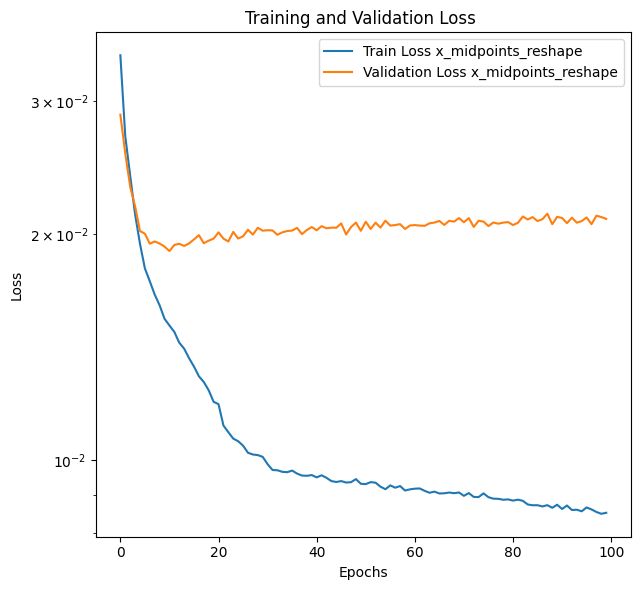

In [15]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# loaded_model = tf.keras.models.load_model(
#     "/home/da886/Electron Counting Extended Arch/Weights For Classes/3onlymixed.keras",safe_mode=False,
#     custom_objects={'DynamicExponentCallback': DynamicExponentCallback, 'custom_loss': custom_loss}
# )


/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
model_builder.model.save('/home/da886/Final Electron counting project/Experimental weights/originalHuber5fixed.keras')

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


W0000 00:00:1726770919.972282 2389045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.972540 2389026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.973498 2389045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.973522 2389026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.973983 2389045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.974005 2389026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.974471 2389045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.974553 2389026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726770919.974918 2389045 gp

Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 12, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 13, batch shape: (800,

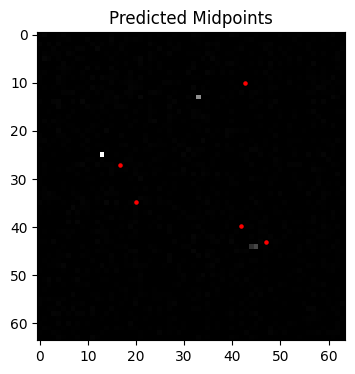

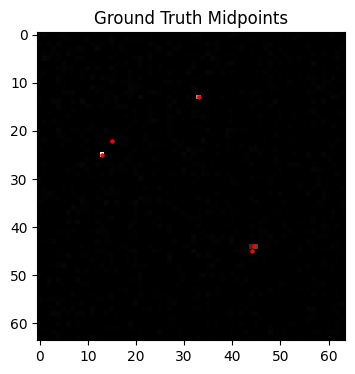

In [27]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


In [273]:
all_true_midpoints[11548]

array([[[0.78126204, 0.734375  ],
        [0.828125  , 0.796875  ],
        [0.703125  , 0.8125    ]]], dtype=float32)

In [274]:
all_pred_midpoints[11548]

array([[[3.3416320e-06, 6.6482944e-06],
        [1.1129316e-02, 1.0827443e-02],
        [8.3547854e-01, 8.0358070e-01]]], dtype=float32)

In [250]:
len(all_images)

24000

In [183]:
data.shape

TensorShape([800, 64, 64])

In [191]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, midpoints):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Predicted Midpoint Visualization")

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# def visualize_midpoints2(image, midpoints):
#     """
#     Visualizes ground truth midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
#     image_np = image
#     midpoints_np = midpoints
#     denormalized_image = image_np 

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Ground Truth Midpoint Visualization")

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         # if x != 0 and y != 0:  # Only plot if the point is not (0, 0)
#         if x >= 3 and y >= 3:
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Example usage with random data
# t = np.random.randint(0, 800)

# # t= 100 #### noise example
# # visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*np.max(centers))
# # visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*np.max(centers))
# visualize_midpoints(tf.convert_to_tensor(data[t]), tf.convert_to_tensor(outputs[2][t,0,:,:])*64)
# visualize_midpoints2(tf.convert_to_tensor(data[t]), tf.convert_to_tensor(pred[2][t,0,:,:])*64)


code to visualize Josh's edit

In [233]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - title: The title of the plot.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title(title)

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Example processing and visualization
# t = np.random.randint(0, 800)

# # Visualize one batch at a time
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):
#     predictions = model_builder.model.predict(data_batch)

#     # Select a random image from the batch
#     data_sample = data_batch[t]
#     pred_midpoints = predictions[t, 0, :, :]
#     true_midpoints = midpoints_batch[t, 0, :, :]

#     # Visualize predicted and true midpoints
#     visualize_midpoints(data_sample, pred_midpoints * 64, title="Predicted Midpoints")
#     visualize_midpoints(data_sample, true_midpoints * 64, title="Ground Truth Midpoints")

#     # Only visualize for one batch, break after the first
#     break


In [45]:
# model_builder.model.save('/home/da886/Electron Counting Extended Arch/Overfitted weights/increased_model_Padded_weights.keras')

In [268]:
val_loss = model_builder.model.evaluate(val_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.0136


In [148]:

# Squeeze the singleton dimension at index 1 from both predictions and targets
output = np.squeeze(output, axis=1)
targets = np.squeeze(targets, axis=1)


In [145]:
output.shape

(800, 3, 2)

Code to visualize taking just n batch

In [260]:

# # Initialize variables to track the min and max MSE
# min_mse = float('inf')
# max_mse = float('-inf')
# min_mse_index = -1
# max_mse_index = -1

# # Loop through each prediction to calculate the MSE
# for i in range(len(output)):
#     mse = np.mean((output[i] - targets[i]) ** 2)
    
#     if mse < min_mse:
#         min_mse = mse
#         min_mse_index = i
    
#     if mse > max_mse:
#         max_mse = mse
#         max_mse_index = i

# # Function to plot an image with its centers
# def plot_image_with_centers(image, true_center, predicted_center, title):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image.squeeze(), cmap='gray')  

#     # Plot the actual center
#     plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

#     # Plot the predicted center
#     plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

#     plt.title(title)
#     plt.legend()
#     plt.show()

# # Convert inputs to numpy arrays for plotting
# inputs_np = data.numpy()

# # Plotting the image with the least MSE
# plot_image_with_centers(inputs_np[min_mse_index],
#                         targets[min_mse_index]*64,
#                         output[min_mse_index]*64,
#                         f'Image with Least MSE. MSE: {min_mse:.4f}')

# # Plotting the image with the largest MSE
# plot_image_with_centers(inputs_np[max_mse_index],
#                         targets[max_mse_index]*64,
#                         output[max_mse_index]*64,
#                         f'Image with Largest MSE. MSE: {max_mse:.4f}')


In [285]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Initialize variables to track the min and max MSE
# min_mse = float('inf')
# max_mse = float('-inf')
# min_mse_index = -1
# max_mse_index = -1

# # Loop through each prediction to calculate the MSE
# for i in range(len(all_pred_midpoints)):
#     mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) ** 2)
    
#     if mse < min_mse:
#         min_mse = mse
#         min_mse_index = i
    
#     if mse > max_mse:
#         max_mse = mse
#         max_mse_index = i

# # Function to plot an image with its centers
# def plot_image_with_centers(image, true_center, predicted_center, title):
#     plt.figure(figsize=(4, 4))
#     plt.imshow(image.squeeze(), cmap='gray')  

#     # Plot the actual center
#     plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

#     # Plot the predicted center
#     plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

#     plt.title(title)
#     plt.legend()
#     plt.show()

# # Plotting the image with the least MSE
# plot_image_with_centers(all_images[min_mse_index],
#                         all_true_midpoints[min_mse_index] * 64,  # Adjust for scaling if needed
#                         all_pred_midpoints[min_mse_index] * 64,  # Adjust for scaling if needed
#                         f'Image with Least MSE. MSE: {min_mse:.4f}')

# # Plotting the image with the largest MSE
# plot_image_with_centers(all_images[max_mse_index],
#                         all_true_midpoints[max_mse_index] * 64,  # Adjust for scaling if needed
#                         all_pred_midpoints[max_mse_index] * 64,  # Adjust for scaling if needed
#                         f'Image with Largest MSE. MSE: {max_mse:.4f}')


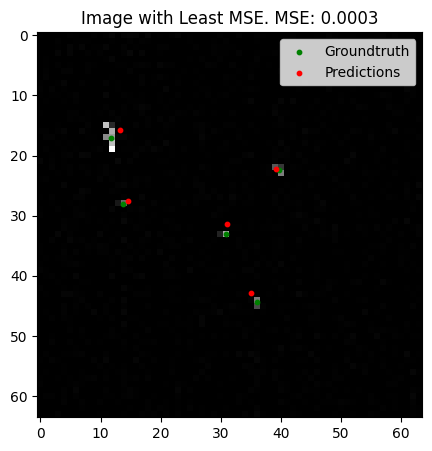

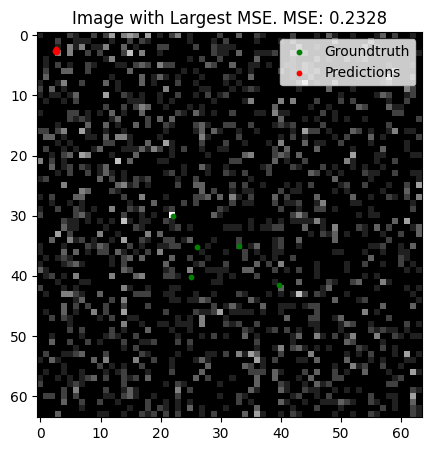

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) ** 2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [263]:
max_mse_index

11548